<center><p float="center">
  <img src="https://upload.wikimedia.org/wikipedia/commons/e/e9/4_RGB_McCombs_School_Brand_Branded.png" width="300" height="100"/>
  <img src="https://mma.prnewswire.com/media/1458111/Great_Learning_Logo.jpg?p=facebook" width="200" height="100"/>
</p></center>

<center><font size=10>Generative AI for Business Applications</center></font>
<center><font size=6>Retrieval Augmented Generation - Week 3</center></font>

<center><p float="center">
  <img src="https://images.pexels.com/photos/5185082/pexels-photo-5185082.jpeg" width=720></a>
<center><font size=6>LLM-Powered Research Assistant</center></font>

# Problem Statement

## Business Context

In today's competitive and rapidly evolving technological landscape, research and development teams are often overwhelmed by the volume of new scientific publications. Manually reviewing, summarizing, and extracting key insights from these documents is time-consuming and can delay critical innovation decisions. To address this challenge, a technology consulting firm is building an LLM-powered assistant designed to streamline the literature review process. This AI assistant will automatically extract summaries, metadata, and emerging trends from collections of research papers, significantly reducing manual effort and accelerating the discovery of relevant information. By applying this solution to a curated dataset of recent publications, the firm aims to demonstrate how advanced language models can enhance productivity and support timely, data-driven innovation across research-intensive domains.

##  Objective

The goal is to develop a prototype that demonstrates how Natural Language Processing (NLP) can support research teams in efficiently querying large scientific documents using Retrieval-Augmented Generation (RAG).

Specifically, the system aims to:

* Answer user questions by retrieving relevant content from long research papers.
* Support natural-language queries without requiring users to read the entire document.
* Simulate an intelligent assistant that simplifies literature review workflows.

This case study focuses on building a small part of that broader solution, a system where users upload lengthy research PDFs, and the model provides grounded, relevant answers using RAG. This enables researchers to extract targeted information faster and make informed decisions more quickly.

Through successful implementation, the organization seeks to improve research productivity, reduce time spent on manual document review, and accelerate innovation.


## Data Description

The dataset consists of four research papers in PDF format focused on Prompt Engineering.

Here are the research paper names and links:

1. **Language Models are Few-Shot Learners**
   *Authors: Tom B. Brown et al. (OpenAI)*

2. **The Power of Scale for Parameter-Efficient Prompt Tuning**
   *Authors: Brian Lester, Rami Al-Rfou, Noah Constant (Google Research)*

3. **AutoPrompt: Eliciting Knowledge from Language Models with Automatically Generated Prompts**
   *Authors: Taylor Shin, Yasaman Razeghi, Robert L. Logan IV, Eric Wallace, Sameer Singh*

4. **Prompt Programming for Large Language Models: Beyond the Few-Shot Paradigm**
   *Authors: Andy J. W. Reynolds, Sam McDonell (Stanford)*



# Installing and Importing Necessary Libraries

In [ ]:
# Install required libraries
!pip install -q langchain_community==0.3.27 \
              langchain==0.3.27 \
              chromadb==1.0.15 \
              pymupdf==1.26.3 \
              tiktoken==0.9.0 \
              ragas==0.3.0 \
              datasets==4.0.0 \
              evaluate==0.4.5

**Note**:
- After running the above cell, kindly restart the runtime (for Google Colab) or notebook kernel (for Jupyter Notebook), and run all cells sequentially from the next cell.
- On executing the above line of code, you might see a warning regarding package dependencies. This error message can be ignored as the above code ensures that all necessary libraries and their dependencies are maintained to successfully execute the code in ***this notebook***.

***Prompt:***

<font size=3 color="#4682B4"><b>I want to evaluate the performance of a Retrieval-Augmented Generation (RAG) system using a set of documents and user queries. Help me import the necessary Python libraries to:

1. Read and manipulate data (CSV, JSON) </ul>
2. Interact with the operating system (e.g., environment variables)
3. Load and split PDF documents into manageable text chunks
4. Generate vector embeddings using OpenAI
5. Store and retrieve vectors using Chroma vector database
6. Evaluate RAG performance using metrics such as Faithfulness, Answer Relevancy, and LLM Context Precision
7. Structure evaluation data using the Hugging Face `datasets` library
8. Connect to OpenAI's LLMs via LangChain

</font>

<font size=3 color="#4682B4"><b>

</font>

In [ ]:
# Import core libraries
import os                                                                       # Interact with the operating system (e.g., set environment variables)
import json                                                                     # Read/write JSON data

# Import libraries for working with PDFs and OpenAI
from langchain.document_loaders import PyMuPDFLoader                            # Load and extract text from PDF files
from openai import OpenAI                                                       # Access OpenAI's models and services

# Import libraries for processing dataframes and text
import tiktoken                                                                 # Tokenizer used for counting and splitting text for models
import pandas as pd                                                             # Load, manipulate, and analyze tabular data

# Import LangChain components for data loading, chunking, embedding, and vector DBs
from langchain.text_splitter import RecursiveCharacterTextSplitter              # Break text into overlapping chunks for processing
from langchain.embeddings.openai import OpenAIEmbeddings                        # Create vector embeddings using OpenAI's models  # type: ignore
from langchain.vectorstores import Chroma                                       # Store and search vector embeddings using Chroma DB  # type: ignore

# Import components to run evaluation on RAG pipeline outputs
from ragas import evaluate
from ragas.metrics import (
    Faithfulness,
    AnswerRelevancy,
    LLMContextPrecisionWithoutReference,
)
from datasets import Dataset                                                    # Used to structure the input (questions, answers, contexts etc.) in tabular format
from langchain_openai import ChatOpenAI                                         # This is needed since LLM is used in metric computation

# Question Answering using LLM

### OpenAI API Calling



***Prompt***:

<font size=3 color="#4682B4"><b> Read the API key and base URL from a config file, set them as environment variables, and initialize the OpenAI client.
</font>

In [ ]:
# Load the JSON file and extract values
file_name = 'config.json'                                                       # Name of the configuration file
with open(file_name, 'r') as file:                                              # Open the config file in read mode
    config = json.load(file)                                                    # Load the JSON content as a dictionary
    API_KEY = config.get("API_KEY")                                             # Extract the API key from the config
    OPENAI_API_BASE = config.get("OPENAI_API_BASE")                             # Extract the OpenAI base URL from the config

# Store API credentials in environment variables
os.environ['OPENAI_API_KEY'] = API_KEY                                          # Set API key as environment variable
os.environ["OPENAI_BASE_URL"] = OPENAI_API_BASE                                 # Set API base URL as environment variable

# Initialize OpenAI client
client = OpenAI()                                                               # Create an instance of the OpenAI client

### Defining the function to Generate a Response From the LLM

***Prompt***:

<font size=3 color="#4682B4"><b> Create a function to query the OpenAI model using user input and return the generated response.
</font>

In [ ]:
# Define a function to get a response
def response(user_prompt, max_tokens=500, temperature=0.3, top_p=0.95):
    # Create a chat completion using the OpenAI client
    completion = client.chat.completions.create(
        model="gpt-4o-mini",                                                     # Specify the model to use
        messages=[
            {"role": "user", "content": user_prompt}                            # User prompt is the input/query to respond to
        ],
        max_tokens=max_tokens,                                                  # Max number of tokens to generate in the response
        temperature=temperature,                                                # Controls randomness in output
        top_p=top_p                                                             # Controls diversity via nucleus sampling
    )
    return completion.choices[0].message.content                                # Return the text content from the model's reply                                                        # Execute the function with the prompts

### Question 1: What is the difference between zero-shot and few-shot prompting in language models?

In [ ]:
# Define the question
question_1 = "What is the difference between zero-shot and few-shot prompting in language models?"
base_prompt_response_1 = response(question_1)
base_prompt_response_1

### Question 2: How does the performance of in-context learning change based on the number of examples provided and the nature of the task?

In [ ]:
question_2 = "How does the performance of in-context learning change based on the number of examples provided and the nature of the task?"
base_prompt_response_2 = response(question_2)
base_prompt_response_2

### Question 3: What are the limitations of discrete prompts, and how to overcome them?

In [ ]:
question_3 = "What are the limitations of discrete prompts, and how to overcome them?"
base_prompt_response_3 = response(question_3)
base_prompt_response_3

### Storing the generated outputs from the base prompt


***Prompt***:

<font size=3 color="#4682B4"><b> Create a DataFrame to store questions and their responses, and preview the first few rows.
</font>

In [ ]:
# Create the DataFrame
result_df = pd.DataFrame({
    "questions": [question_1, question_2, question_3],
    "base_prompt_responses": [base_prompt_response_1, base_prompt_response_2, base_prompt_response_3]})

# Display the DataFrame
result_df.head()

# Data Preparation for RAG

## Loading the Data

In [ ]:
# uncomment and run the below code snippets if the dataset is present in the Google Drive
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
! unzip "/content/ResearchPaper.zip"

In [ ]:
# Uploading multiple pdfs:
from glob import glob

# Path to folder with PDFs
DOC_FOLDER = "ResearchPaper/"
pdf_files = glob(DOC_FOLDER + "*.pdf")

In [ ]:
pdf_files

***Prompt***:

<font size=3 color="#4682B4"><b>Read each PDF file from the pdf_files list using PyMuPDFLoader and store the extracted documents in all_documents.
</font>

In [ ]:
# Load each PDF file and store the documents
all_documents = []
for pdf_file in pdf_files:
    loader = PyMuPDFLoader(pdf_file)
    documents = loader.load()
    all_documents.extend(documents)


## Data Chunking

### Chunk the PDF into Manageable Text Sections

***Prompt***:

<font size=3 color="#4682B4"><b> Create a text splitter to divide content into chunks.
</font>

In [ ]:
# Initialize a text splitter that uses OpenAI's token encoder
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    encoding_name='cl100k_base',                                                # Encoding used by popular LLMs
    chunk_size=512,                                                             # Each chunk will have up to 512 character
)

### Split the Loaded PDF into Chunks for Further Processing

***Prompt***:

<font size=3 color="#4682B4"><b>Apply the text splitter on all_documents to create smaller chunks.
</font>

In [ ]:
# Use the text splitter to divide the PDF content into smaller chunks
document_chunks = text_splitter.split_documents(all_documents)                  # Returns a list of chunked documents

### Check the Number of Chunks Created

***Prompt***:

<font size=3 color="#4682B4"><b> Display the total number of chunks generated from the documents.
</font>

In [ ]:
print(f"Created {len(document_chunks)} chunks.")

## Generate Vector Embeddings for Text Chunks Using OpenAI

***Prompt***:

<font size=3 color="#4682B4"><b> Initialize the OpenAI embedding model using API credentials, create embeddings for the first two chunks, and display the vector dimension.
</font>

In [ ]:
# Initialize the OpenAI Embeddings model with API credentials
embedding_model = OpenAIEmbeddings(
    openai_api_key=API_KEY,                                                     # Your OpenAI API key for authentication
    openai_api_base=OPENAI_API_BASE                                             # The OpenAI API base URL endpoint
)

# Generate embeddings (vector representations) for the first two document chunks
embedding_1 = embedding_model.embed_query(document_chunks[0].page_content)      # Embedding for chunk 0
embedding_2 = embedding_model.embed_query(document_chunks[1].page_content)      # Embedding for chunk 1

# Check and print the dimension (length) of the embedding vector
print("Dimension of the embedding vector ", len(embedding_1))                   # Typically 1536 or 2048 depending on model

Below is a sample code snippet you can refer to for using an open-source embedding model.

In [ ]:
# file_name = 'config.json'                                                       # Name of the configuration file
# with open(file_name, 'r') as file:                                              # Open the config file in read mode
#     config = json.load(file)                                                    # Load the JSON content as a dictionary
#     HF_TOKEN = config.get("HF_TOKEN")


# # Store API credentials in environment variables
# os.environ['HF_TOKEN'] = HF_TOKEN


In [ ]:
# from langchain_community.embeddings.sentence_transformer import SentenceTransformerEmbeddings

# # Use HuggingFaceEmbeddings wrapper with SentenceTransformer model
# embedding_model = SentenceTransformerEmbeddings(model_name='all-MiniLM-L6-v2')


## Vector Database Creation

***Prompt***:

<font size=3 color="#4682B4"><b> Convert chunks into vector representations using the embedding model.
</font>

In [ ]:
# Building the vector store and saving it to disk for future use
vectorstore = Chroma.from_documents(
    document_chunks,                                                            # Documents to index
    embedding_model                                                             # Embedding model for converting text to vectors
 )

## Retrieval and Response Generation using Vector Search

### Convert Vector Database into a Retriever and Retrieve Relevant Documents

***Prompt***:

<font size=3 color="#4682B4"><b> Set up a similarity-based retriever to fetch the top 5 most relevant document chunks.
</font>

In [ ]:
# Wraping the vector store into a retriever object to fetch the most relevant documents for a given query using similarity search
retriever = vectorstore.as_retriever(
    search_type='similarity',                                                   # Use similarity search (based on vector distance)
    search_kwargs={'k': 5}                                                      # Retrieve top 5 most relevant documents
)

## System and User Prompt Template

Prompts guide the model to generate accurate responses. Here, we define two parts:

    1. The system message describing the assistant's role.
    2. A user message template including context and the question.

In [ ]:
# Define the system prompt for the model
qna_system_message = """
You are an AI assistant designed to support research teams in efficiently reviewing scientific literature. Your task is to provide evidence-based, concise, and relevant summaries based on the context provided from research papers.

User input will include the necessary context for you to answer their questions. This context will begin with the token:

###Context
The context contains excerpts from one or more research papers, along with associated metadata such as titles, authors, abstracts, keywords, and specific sections relevant to the query.

When crafting your response
-Use only the provided context to answer the question.
-If the answer is found in the context, respond with concise and insight-focused summaries.
-Include the paper title and, where applicable, arXiv ID or section reference as the source.
-If the question is unrelated to the context or the context is empty, clearly respond with: "Sorry, this is out of my knowledge base."


Please adhere to the following response guidelines:
-Provide clear, direct answers using only the given context.
-Do not include any additional information outside of the context.
-Avoid rephrasing or generalizing unless explicitly relevant to the question.
-If no relevant answer exists in the context, respond with: "Sorry, this is out of my knowledge base."
-If the context is not provided, your response should also be: "Sorry, this is out of my knowledge base."


Here is an example of how to structure your response:

Answer:
[Answer based on context]

Source:
[Source details with page or section]
"""

In [ ]:
# Define the user message template
qna_user_message_template = """
###Context
Here are some excerpts from GEN AI Research Paper and their sources that are relevant to the Gen AI question mentioned below:
{context}

###Question
{question}
"""

### Response Function

***Prompt***:

<font size=3 color="#4682B4"><b> Create a function to generate RAG-based responses from user input, retrieve relevant document chunks, build context, and use the OpenAI model to generate a context-aware answer.
</font>

In [ ]:
def generate_rag_response(user_input,k=5,max_tokens=500,temperature=0.3,top_p=0.95):
    global qna_system_message,qna_user_message_template
    # Retrieve relevant document chunks
    relevant_document_chunks = retriever.get_relevant_documents(query=user_input,k=k)
    context_list = [d.page_content for d in relevant_document_chunks]

    # Combine document chunks into a single context
    context_for_query = ". ".join(context_list)

    user_message = qna_user_message_template.replace('{context}', context_for_query)
    user_message = user_message.replace('{question}', user_input)

    # Generate the response
    try:
        response = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[
            {"role": "system", "content": qna_system_message},
            {"role": "user", "content": user_message}
        ],
        max_tokens=max_tokens,
        temperature=temperature,
        top_p=top_p
        )
        # Extract and print the generated text from the response
        response = response.choices[0].message.content.strip()
    except Exception as e:
        response = f'Sorry, I encountered the following error: \n {e}'

    return response

#### Below are sample code snippets you can refer to for downloading the open source model and implementing the function to generate a RAG-based response.

In [ ]:
# !pip install transformers torch

In [ ]:
# from transformers import AutoModelForCausalLM, AutoTokenizer
# import torch

# # Define model name from Hugging Face
# MISTRAL_MODEL_NAME = "mistralai/Mistral-7B-Instruct-v0.1"

# # Load tokenizer and model
# tokenizer = AutoTokenizer.from_pretrained(MISTRAL_MODEL_NAME)
# model = AutoModelForCausalLM.from_pretrained(MISTRAL_MODEL_NAME,token=HF_TOKEN)

# # Move model to GPU if available
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.to(device)

In [ ]:
# def generate_rag_response_mistral(user_input, k=5, max_tokens=500, temperature=0.7, top_p=0.95):
#     global qna_system_message, qna_user_message_template, retriever, model, tokenizer

#     try:

#         relevant_chunks = retriever.get_relevant_documents(query=user_input, k=k)
#         context_list = [doc.page_content for doc in relevant_chunks]
#         context = ". ".join(context_list)


#         user_message = qna_user_message_template.replace("{context}", context)
#         user_message = user_message.replace("{question}", user_input)
#         prompt = f"{qna_system_message.strip()}\n\n{user_message.strip()}"


#         inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
#         outputs = model.generate(
#             **inputs,
#             max_new_tokens=max_tokens,
#             temperature=temperature,
#             top_p=top_p,
#             do_sample=True
#         )

#         response = tokenizer.decode(outputs[0], skip_special_tokens=True).strip()

#     except Exception as e:
#         response = f"Sorry, I encountered the following error:\n{e}"

#     return response


# Question Answering using RAG

### Question 1: What is the difference between zero-shot and few-shot prompting in language models?

In [ ]:
response_with_rag_1 = generate_rag_response(question_1)
response_with_rag_1

### Question 2: How does the performance of in-context learning change based on the number of examples provided and the nature of the task?

In [ ]:
response_with_rag_2 = generate_rag_response(question_2)
response_with_rag_2

### Question 3: What are the limitations of discrete prompts, and how to overcome them?

In [ ]:
response_with_rag_3 = generate_rag_response(question_3)
response_with_rag_3

### Storing the RAG system outputs


***Prompt***:

<font size=3 color="#4682B4"><b>
Insert model responses generated with RAG pipeline into a new column of result_df and preview the updated DataFrame.
</font>

In [ ]:
# Add the results to a new column in the DataFrame
result_df['responses_with_RAG'] = [response_with_rag_1, response_with_rag_2, response_with_rag_3]

# Display the DataFrame
result_df.head()

# Output Evaluation

## Evaluating Output with LLM-as-a-judge



### **Defining required System Prompts**

In [ ]:
groundedness_rater_system_message = """
You are tasked with rating AI generated answers to questions posed by users.
You will be presented a question, context used by the AI system to generate the answer and an AI generated answer to the question.
In the input, the question will begin with ###Question, the context will begin with ###Context while the AI generated answer will begin with ###Answer.

Evaluation criteria:
The task is to judge the extent to which the metric is followed by the answer.
1 - The metric is not followed at all
2 - The metric is followed only to a limited extent
3 - The metric is followed to a good extent
4 - The metric is followed mostly
5 - The metric is followed completely

Metric:
The answer should be derived only from the information presented in the context

Instructions:
1. First write down the steps that are needed to evaluate the answer as per the metric.
2. Give a step-by-step explanation if the answer adheres to the metric considering the question and context as the input.
3. Next, evaluate the extent to which the metric is followed.
4. Use the previous information to rate the answer using the evaluaton criteria and assign a score.

Return only the Score in last in a dictionary format not json and socre should be in the range of 1 to 5.
Example {groundedness_score:4}
"""

In [ ]:
relevance_rater_system_message = """
You are tasked with rating AI generated answers to questions posed by users.
You will be presented a question, context used by the AI system to generate the answer and an AI generated answer to the question.
In the input, the question will begin with ###Question, the context will begin with ###Context while the AI generated answer will begin with ###Answer.

Evaluation criteria:
The task is to judge the extent to which the metric is followed by the answer.
1 - The metric is not followed at all
2 - The metric is followed only to a limited extent
3 - The metric is followed to a good extent
4 - The metric is followed mostly
5 - The metric is followed completely

Metric:
Relevance measures how well the answer addresses the main aspects of the question, based on the context.
Consider whether all and only the important aspects are contained in the answer when evaluating relevance.

Instructions:
1. First write down the steps that are needed to evaluate the context as per the metric.
2. Give a step-by-step explanation if the context adheres to the metric considering the question as the input.
3. Next, evaluate the extent to which the metric is followed.
4. Use the previous information to rate the context using the evaluaton criteria and assign a score.
Return only the Score in last in a dictionary format not json and score should be in the range of 1 to 5.
Example {relevance_score:4}
"""

In [ ]:
user_message_template = """
###Question
{question}

###Context
{context}

###Answer
{answer}
"""

***Prompt***:

<font size=3 color="#4682B4"><b>Create a function to assess groundedness and relevance that takes a question and answer, retrieves relevant context, and uses predefined prompts to evaluate the response using the OpenAI model.
</font>

In [ ]:
def generate_ground_relevance_response(user_input,response, max_tokens=500,temperature=0,top_p=0.95):
    global qna_user_message_template

    context_for_query = [doc.page_content for doc in retriever.get_relevant_documents(user_input, k=5)]

    # Combine user_prompt and system_message to create the prompt
    groundedness_prompt = f"""[INST]{groundedness_rater_system_message}\n
                {'user'}: {user_message_template.format(context=context_for_query, question=user_input, answer=response)}
                [/INST]"""

    # Combine user_prompt and system_message to create the prompt
    relevance_prompt = f"""[INST]{relevance_rater_system_message}\n
                {'user'}: {user_message_template.format(context=context_for_query, question=user_input, answer=response)}
                [/INST]"""

    response_1 = client.chat.completions.create(
            model="gpt-4o",
            messages=[
                {"role": "user", "content": groundedness_prompt}
                ],
            max_tokens=max_tokens,
            temperature=temperature,
            top_p=top_p
            )

    response_2 = client.chat.completions.create(
            model="gpt-4o",
            messages=[
                {"role": "user", "content": relevance_prompt}
                ],
            max_tokens=max_tokens,
            temperature=temperature,
            top_p=top_p
            )

    return response_1.choices[0].message.content,response_2.choices[0].message.content

### **Evaluation 1: Base Prompt Response Evaluation**

In [ ]:
# Question 1
llm_judge_base_ground_1,llm_judge_base_rel_1 = generate_ground_relevance_response(user_input=question_1, response=result_df.base_prompt_responses[0])
print(llm_judge_base_ground_1,end="\n\n")
print(llm_judge_base_rel_1)

In [ ]:
# Question 2
llm_judge_base_ground_2,llm_judge_base_rel_2 = generate_ground_relevance_response(user_input=result_df.questions[1], response=result_df.base_prompt_responses[1], max_tokens=500)
print(llm_judge_base_ground_2,end="\n\n")
print(llm_judge_base_rel_2)

In [ ]:
# Question 3
llm_judge_base_ground_3,llm_judge_base_rel_3 = generate_ground_relevance_response(user_input=result_df.questions[2],response=result_df.base_prompt_responses[2], max_tokens=500)
print(llm_judge_base_ground_3,end="\n\n")
print(llm_judge_base_rel_3)

> **Note:** We are using `llm_judge_base_ground_1[-2]` to extract the second-to-last element from the model's output because the prompt is structured to return the final score as a dictionary at the end, like this: `{'relevance_score': 5}`.


In [ ]:
# Create a DataFrame to store the base prompt evaluation results
base_prompt_evaluation_df = pd.DataFrame({
    "question": [question_1, question_2, question_3],
    "base_prompt_response": [result_df.base_prompt_responses[0], result_df.base_prompt_responses[1], result_df.base_prompt_responses[2]],
    "groundedness_score": [llm_judge_base_ground_1[-2], llm_judge_base_ground_2[-2], llm_judge_base_ground_3[-2]],
    "relevance_score": [llm_judge_base_rel_1[-2], llm_judge_base_rel_2[-2], llm_judge_base_rel_3[-2]]
})

base_prompt_evaluation_df['groundedness_score'] = pd.to_numeric(base_prompt_evaluation_df['groundedness_score'], errors='coerce')
base_prompt_evaluation_df['relevance_score'] = pd.to_numeric(base_prompt_evaluation_df['relevance_score'], errors='coerce')

# Display the DataFrame
display(base_prompt_evaluation_df)

### **Evaluation 2: RAG Response Evaluation**

In [ ]:
# Question 1
llm_judge_rag_ground_1,llm_judge_rag_rel_1 = generate_ground_relevance_response(user_input=result_df.questions[0], response=result_df.responses_with_RAG[0], max_tokens=500)
print(llm_judge_rag_ground_1,end="\n\n")
print(llm_judge_rag_rel_1)

In [ ]:
# Question 2
llm_judge_rag_ground_2,llm_judge_rag_rel_2 = generate_ground_relevance_response(user_input=result_df.questions[1], response=result_df.responses_with_RAG[1], max_tokens=500)
print(llm_judge_rag_ground_2,end="\n\n")
print(llm_judge_rag_rel_2)

In [ ]:
# Question 3
llm_judge_rag_ground_3,llm_judge_rag_rel_3 = generate_ground_relevance_response(user_input=result_df.questions[2], response=result_df.responses_with_RAG[2], max_tokens=500)
print(llm_judge_rag_ground_3,end="\n\n")
print(llm_judge_rag_rel_3)

In [ ]:
# Create a DataFrame to store the RAG response evaluation results
rag_response_evaluation_df = pd.DataFrame({
    "question": [question_1, question_2, question_3],
    "rag_response": [result_df.responses_with_RAG[0], result_df.responses_with_RAG[1], result_df.responses_with_RAG[2]],
    "groundedness_score": [llm_judge_rag_ground_1[-2], llm_judge_rag_ground_2[-2], llm_judge_rag_ground_3[-2]],
    "relevance_score": [llm_judge_rag_rel_1[-2], llm_judge_rag_rel_2[-2], llm_judge_rag_rel_3[-2]]
})

rag_response_evaluation_df['groundedness_score'] = pd.to_numeric(rag_response_evaluation_df['groundedness_score'], errors='coerce')
rag_response_evaluation_df['relevance_score'] = pd.to_numeric(rag_response_evaluation_df['relevance_score'], errors='coerce')


# Display the DataFrame
display(rag_response_evaluation_df)

In [ ]:
print("Average scores for Base Prompt Evaluation:")
print(base_prompt_evaluation_df[['groundedness_score', 'relevance_score']].mean(numeric_only=True))
print("\nAverage scores for RAG Response Evaluation:")
print(rag_response_evaluation_df[['groundedness_score', 'relevance_score']].mean(numeric_only=True))

### Observations

- RAG consistently achieves the highest scores in both groundedness and relevance. This is expected since RAG leverages retrieved documents or external knowledge to generate accurate and well-supported responses.

- Base Prompt responses generally score lower in groundedness, often containing generic or hallucinated statements due to the absence of prompt structure and supporting context.

- RAG’s superior groundedness scores suggest that its answers closely align with retrieved information, minimizing factual errors and enhancing trustworthiness.


## Evaluating Output with RAGAS

<h4><b> What is RAGAS? </b></h4>


**RAGAS** (Retrieval-Augmented Generation Assessment Score) is an open-source Python framework designed to **evaluate RAG pipelines** using a set of quantitative metrics. The framework assesses:

- **Answer relevance**: How well the generated answer addresses the user's question  
- **Answer faithfulness**: Whether the answer is supported by the retrieved documents  
- **Context utility**: How useful the retrieved documents were in producing the answer

RAGAS requires **structured input** wrapped in a **Hugging Face `Dataset` object**, containing:

- The user's query  
- Retrieved documents or context chunks  
- The generated answer from the RAG system  
- *(Optional)* A reference answer for comparison  

With the inputs, it produces **per-example metric scores** that are **normalized between 0 and 1**, where higher values indicate better performance.

<br>

*To explore RAGAS further, check out the official [RAGAS Documentation](https://docs.ragas.io).*

<h4><b> RAGAS Metrics </b></h4>

It provides several metrics, some of which can work without reference answers, making it easier to assess real-world systems where the perfect answer may not exist.


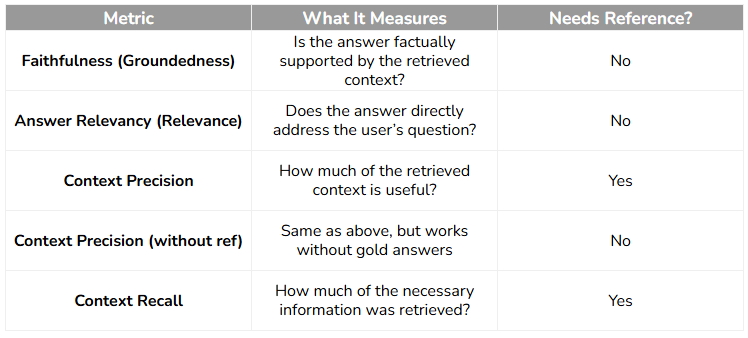

Since we don't have reference answers, we will evaluate our RAG pipeline using the following:
* **Faithfulness**
* **Answer Relevancy**
* **Context Precision (Without Reference)**

### **Initialize the evaluator LLM and Metrics**

***Prompt***:

<font size=3 color="#4682B4"><b>Set up the evaluator LLM using ChatOpenAI and define the metrics for faithfulness, answer relevancy, and context precision.
</font>

In [ ]:
# Initialize the evaluator LLM
evaluator_llm = ChatOpenAI(model_name="gpt-4o", temperature=0)

# Initialize evaluation metrics
faithfulness = Faithfulness()
answer_relevancy = AnswerRelevancy()
context_precision = LLMContextPrecisionWithoutReference()

### **Prepare Data: Questions, Contexts, and Responses**

***Prompt***:

<font size=3 color="#4682B4"><b> Extract questions and different response types from result_df, and retrieve top-6 relevant context documents for each question.
</font>

In [ ]:
questions = result_df.questions.to_list()                                       # List of user questions
base_prompt_responses = result_df.base_prompt_responses.to_list()               # Responses without prompt engineering
responses_with_rag = result_df.responses_with_RAG.to_list()                     # Responses from RAG pipeline

# Retrieve top-k documents as context for each question
contexts = [
    [doc.page_content for doc in retriever.get_relevant_documents(q, k=6)]      # Get top 6 docs for each question
    for q in questions
]

### **Evaluation 1: Base Prompt Response Evaluation**

***Prompt***:

<font size=3 color="#4682B4"><b>Wrap base-prompt generated answers into a Dataset, run RAGAS evaluation using the defined metrics, and convert the results to a DataFrame.
</font>

In [ ]:
# Wrap into HuggingFace Dataset
ragas_dataset_base_prompt = Dataset.from_dict({
    "question": questions,
    "answer": base_prompt_responses,
    "contexts": contexts,
    "reference": questions
})

# Run RAGAS evaluation
result_base_prompt = evaluate(
    ragas_dataset_base_prompt,
    metrics=[
        answer_relevancy,
        context_precision,
        faithfulness,
    ],
    llm=evaluator_llm,
    embeddings=embedding_model
)

# Convert results to DataFrame
df_base_prompt = result_base_prompt.to_pandas()
df_base_prompt

### **Evaluation 2: RAG Response Evaluation**

***Prompt***:

<font size=3 color="#4682B4"><b>Wrap RAG-generated answers into a Dataset, run RAGAS evaluation using the defined metrics, and convert the results to a DataFrame.


</font>

In [ ]:
# Wrap into HuggingFace Dataset
ragas_dataset_with_RAG = Dataset.from_dict({
    "question": questions,
    "answer": responses_with_rag,
    "contexts": contexts,
    "reference": questions
})

# Run RAGAS evaluation
result_with_rag = evaluate(
    ragas_dataset_with_RAG,
    metrics=[
        answer_relevancy,
        context_precision,
        faithfulness,
    ],
    llm=evaluator_llm,
    embeddings=embedding_model
)

# Convert results to DataFrame
df_rag = result_with_rag.to_pandas()
df_rag

***Prompt***:

<font size=3 color="#4682B4"><b>Print the mean values of RAGAS metrics for base prompts and RAG-based outputs.

</font>

In [ ]:
print("Average scores for Base Prompt Evaluation:")
print(df_base_prompt.mean(numeric_only=True))
print("\nAverage scores for RAG Response Evaluation:")
print(df_rag.mean(numeric_only=True))

### Observations

* Answer Relevancy remains high (generally above 0.90) in both evaluations, showing that the generated responses are relevant to the user’s questions.
* LLM Context Precision Without Reference sees a slight improvement with RAG, indicating that the retriever consistently returns relevant information for all queries.
* Faithfulness (Groundedness) scores are high in RAG responses, showing that answers are well-supported by the retrieved context. Lower faithfulness scores for the base model indicate inconsistencies between the answers and the context, which is expected since this method does not have access to the actual context.


# [OPTIONAL] Deployment

The deployment section is only meant to demonstrate the research assistant in action; we won’t be diving deep into the code here.


## Streamlit on Hugging Face

### app.py

**NOTE**: You can use this prompt to generate the code for buidling the Streamlit app. However, a few minor adjustments might be needed afterwards.

***Prompt***:

<font size=3 color="#4682B4"><b>Build a Streamlit app that lets users upload PDFs and ask questions, with answers generated via OpenAI using RAG.
</font>

In [ ]:
# %%writefile app.py

# import streamlit as st
# import os
# import json
# import requests
# from langchain_community.document_loaders import PyMuPDFLoader
# from openai import OpenAI
# import tiktoken
# import pandas as pd
# from langchain.text_splitter import RecursiveCharacterTextSplitter
# from langchain_community.embeddings.openai import OpenAIEmbeddings
# from langchain_community.vectorstores import Chroma
# import tempfile


# OPENAI_API_KEY = os.environ.get("API_KEY")
# OPENAI_API_BASE = os.environ.get("API_BASE")

# # Initialize OpenAI client
# client = OpenAI(
#     api_key=OPENAI_API_KEY,
#     base_url=OPENAI_API_BASE
# )

# # Define the system prompt for the model
# qna_system_message = """
# You are an AI assistant designed to support research teams in efficiently reviewing scientific literature. Your task is to provide evidence-based, concise, and relevant summaries based on the context provided from research papers.

# User input will include the necessary context for you to answer their questions. This context will begin with the token:

# ###Context
# The context contains excerpts from one or more research papers, along with associated metadata such as titles, authors, abstracts, keywords, and specific sections relevant to the query.

# When crafting your response
# -Use only the provided context to answer the question.
# -If the answer is found in the context, respond with concise and insight-focused summaries.
# -Include the paper title and, where applicable, arXiv ID or section reference as the source.
# -If the question is unrelated to the context or the context is empty, clearly respond with: "Sorry, this is out of my knowledge base."


# Please adhere to the following response guidelines:
# -Provide clear, direct answers using only the given context.
# -Do not include any additional information outside of the context.
# -Avoid rephrasing or generalizing unless explicitly relevant to the question.
# -If no relevant answer exists in the context, respond with: "Sorry, this is out of my knowledge base."
# -If the context is not provided, your response should also be: "Sorry, this is out of my knowledge base."


# Here is an example of how to structure your response:

# Answer:
# [Answer based on context]

# Source:
# [Source details with page or section]
# """

# # Define the user message template
# qna_user_message_template = """
# ###Context
# Here are some excerpts from GEN AI Research Paper and their sources that are relevant to the Gen AI question mentioned below:
# {context}
# ###Question
# {question}
# """

# @st.cache_resource
# def load_and_process_pdfs(uploaded_files):
#     all_documents = []
#     for uploaded_file in uploaded_files:
#         with tempfile.NamedTemporaryFile(delete=False, suffix=".pdf") as tmp_file:
#             tmp_file.write(uploaded_file.getvalue())
#             tmp_file_path = tmp_file.name
#         loader = PyMuPDFLoader(tmp_file_path)
#         documents = loader.load()
#         all_documents.extend(documents)
#         os.remove(tmp_file_path) # Clean up the temporary file
#     text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
#         encoding_name='cl100k_base',
#         chunk_size=1000,
#     )
#     document_chunks = text_splitter.split_documents(all_documents)

#     embedding_model = OpenAIEmbeddings(
#         openai_api_key=OPENAI_API_KEY,
#         openai_api_base=OPENAI_API_BASE
#     )

#     # Create an in-memory vector store (or use a persistent one if needed)
#     vectorstore = Chroma.from_documents(
#         document_chunks,
#         embedding_model
#     )
#     return vectorstore.as_retriever(search_type='similarity', search_kwargs={'k': 5})

# def generate_rag_response(user_input, retriever, max_tokens=500, temperature=0, top_p=0.95):
#     # Retrieve relevant document chunks
#     relevant_document_chunks = retriever.get_relevant_documents(query=user_input)
#     context_list = [d.page_content for d in relevant_document_chunks]

#     # Combine document chunks into a single context
#     context_for_query = ". ".join(context_list)

#     user_message = qna_user_message_template.replace('{context}', context_for_query)
#     user_message = user_message.replace('{question}', user_input)

#     # Generate the response
#     try:
#         response = client.chat.completions.create(
#             model="gpt-4o-mini",
#             messages=[
#                 {"role": "system", "content": qna_system_message},
#                 {"role": "user", "content": user_message}
#             ],
#             max_tokens=max_tokens,
#             temperature=temperature,
#             top_p=top_p
#         )
#         response = response.choices[0].message.content.strip()
#     except Exception as e:
#         response = f'Sorry, I encountered the following error: \n {e}'

#     return response

# # Streamlit App
# st.title("LLM-Powered Research Assistant")

# uploaded_files = st.file_uploader("Upload PDF files", type=["pdf"], accept_multiple_files=True)

# retriever = None
# if uploaded_files:
#     st.info("Processing uploaded PDFs...")
#     retriever = load_and_process_pdfs(uploaded_files)
#     st.success("PDFs processed and ready for questioning!")


# if retriever:
#     user_question = st.text_input("Ask a question about the uploaded documents:")
#     if user_question:
#         with st.spinner("Generating response..."):
#             rag_response = generate_rag_response(user_question, retriever)
#             st.write(rag_response)

### Docker File

In [ ]:
# %%writefile Dockerfile

# FROM python:3.9-slim

# WORKDIR /app

# RUN apt-get update && apt-get install -y \
#     build-essential \
#     curl \
#     software-properties-common \
#     git \
#     && rm -rf /var/lib/apt/lists/*

# COPY requirements.txt ./
# COPY app.py ./
# COPY src/ ./src/

# RUN pip3 install -r requirements.txt

# EXPOSE 8501

# HEALTHCHECK CMD curl --fail http://localhost:8501/_stcore/health

# ENTRYPOINT ["streamlit", "run", "app.py", "--server.port=8501", "--server.address=0.0.0.0","--server.enableXsrfProtection=false"]


### requirements.txt

In [ ]:
# %%writefile requirements.txt

# langchain_community==0.3.27
# langchain==0.3.27
# chromadb==1.0.15
# pymupdf==1.26.3
# tiktoken==0.9.0
# datasets==4.0.0
# evaluate==0.4.5
# streamlit==1.35.0
# openai==1.99.1
# langchain_openai==0.3.28

## Hugging Face Setup

#### 1. Login to Hugging Face

Go to [Hugging face](https://huggingface.co) and sign up or log in to your account.

#### 2. Create a New Space

   * Navigate to [Hugging face Spaces ](https://huggingface.co/spaces).
   * Click **Create New Space**.
   * Fill in:

     * Name for your Space.
     * Space SDK: Select **Docker**.
     * Choose a Docker template: Select **Streamlit**
     * Visibility: Choose *Public* or *Private*.
   * Click **Create Space**.

#### 3. Setup OpenAI tokens




- Open your Hugging Face Space

- Click on the **“Settings”** tab at the top of the Space.

- Scroll down to the **“Repository secrets”** section.

- Click **“Add a new secret”**.

- In the **Name** field, type token name

- In the **Secret** field, paste your secret key

- Click **“Add secret”** to save it.


#### 4. Upload Your Files




   * In the new Space, click the **Files** tab.
   * Delete existing requirements.txt , DockerFile
   * Click Contribute then Upload files and add:

     * `app.py`
     * `requirements.txt`
     * `DockerFile`
   * Commit the upload.

#### 5. Build and Launch



   * Hugging Face will automatically detect the `Dockerfile` and start building the container.
   * Wait a few minutes for the build to complete and the app to go live.

#### 6. Access and Test

* Go to the App tab or the Space URL to view and test your running Streamlit app.



# Conclusion

<font size=4>Business Impact</font>

* **Enhanced Decision-Making**: Quick access to key insights and emerging trends empowers research teams to make informed, timely decisions.
* **Scalable Knowledge Management**: Structured outputs enable better indexing, retrieval, and organization of research content, improving long-term knowledge curation.

This approach lays the groundwork for building intelligent research support systems that are scalable, context-aware, and aligned with the dynamic needs of innovation-driven industries.

<font size=4>Improvement Areas</font>

* The system currently depends on the quality and consistency of input PDFs and may struggle with poorly formatted or scanned documents.
* While the LLM captures high-level insights, deeper domain-specific interpretations may require fine-tuning or human validation.

<font size=6 color='#4682B4'>Power Ahead</font>
___